In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [3]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [4]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [5]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


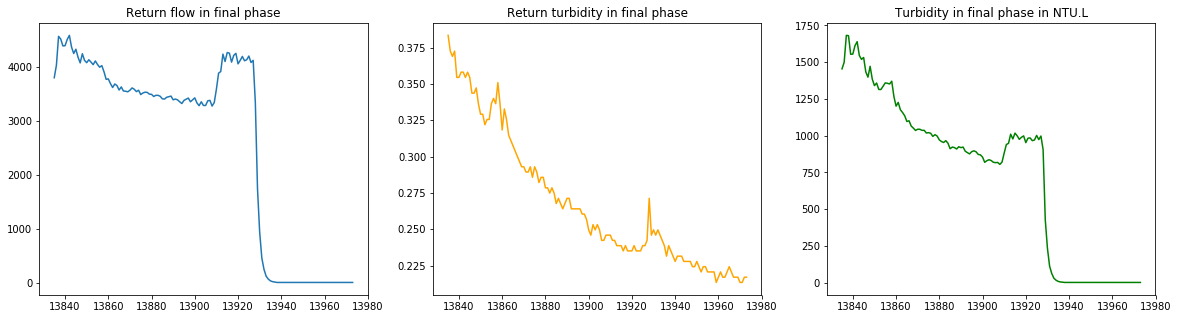

In [6]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

# Попробуем посмотреть на данные. Возможно, получится увидеть некоторые закономерности

In [7]:
import time
import csv
import pickle
import random
import time
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)


Populating the interactive namespace from numpy and matplotlib


In [8]:
train_data_ts = train_data.copy()
train_data_ts.index = train_data_ts['timestamp']

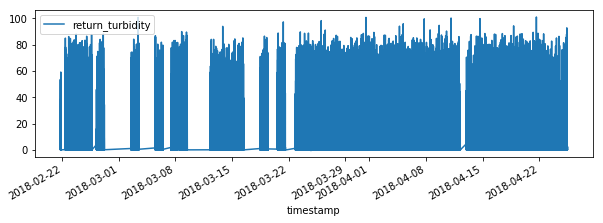

In [9]:
train_data_ts[['return_turbidity']].plot()

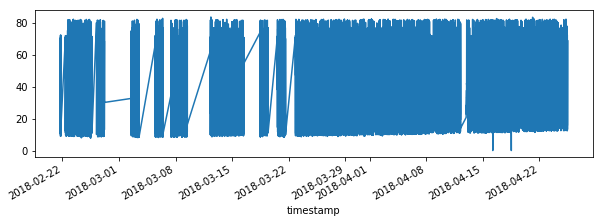

In [10]:
train_data_ts[train_data_ts['phase'] == 'final_rinse']['return_temperature'].plot()

In [11]:
train_data = train_data[train_data['phase'] != 'final_rinse']

In [12]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [13]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

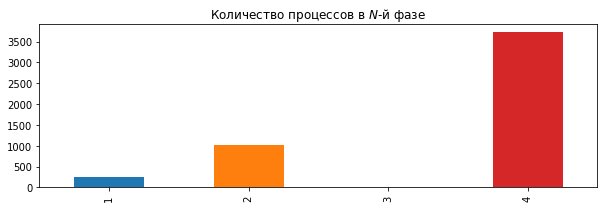

In [14]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

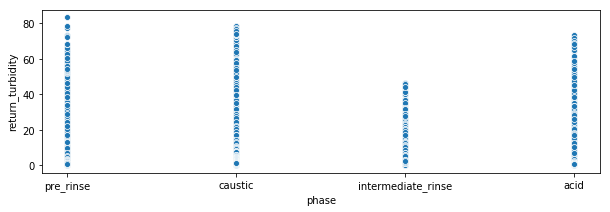

In [15]:
sns.scatterplot(train_data['phase'].head(100000), train_data['return_turbidity'].head(100000))

In [16]:
train_data

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,True,True,False,False,False,False,False,False,True,True,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,True,True,False,False,False,False,False,False,True,True,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,True,True,False,False,False,False,False,False,True,True,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,True,True,False,False,False,False,False,False,True,True,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,True,True,False,False,False,False,False,False,True,True,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,45.398197,44.334373,False,0.0,False,0.0,False
5,20001,405,pre_rinse,2018-04-15 04:20:57,L4,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,True,True,False,False,False,False,False,False,True,True,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,45.385914,44.336000,False,0.0,False,0.0,False
6,20001,405,pre_rinse,2018-04-15 04:20:59,L4,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,True,True,False,False,False,False,False,False,True,True,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,45.369984,44.332523,False,0.0,False,0.0,False
7,20001,405,pre_rinse,2018-04-15 04:21:01,L4,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,True,True,False,False,False,False,False,False,True,True,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,45.381107,44.336490,False,0.0,False,0.0,False
8,20001,405,pre_rinse,2018-04-15 04:21:03,L4,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,True,True,False,False,False,False,False,False,True,True,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,45.402290,44.334263,False,0.0,False,0.0,False


### Создадим уникальный индентификатор фазы для каждого процесса:


In [17]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(13)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

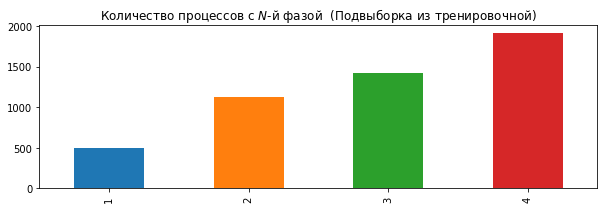

In [18]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [19]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000)).index.nunique()

6

In [20]:
#train_limited_with_phases_gr = train_limited.head(15).copy()
#phases = ['acid', 'caustic', 'pre_rinse']
#cols = train_limited_with_phases_gr.columns
#for col in cols[3:]:
#    for process in train_limited_with_phases_gr['process_id'].unique():
#        for phase in phases:
#            train_limited_with_phases_gr[col + '_' + phase] = train_limited[col][(train_limited['process_id'] == process) & (train_limited['phase'] == phase)]

In [21]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'phase',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

## Сгруппируем по номеру процесса и фазе, в которой он находится. Получится очень разреженная матрица, все NaN заполним нулями, так как фазы не было, то есть значение равно 0. 
## Upd: С нулями получилось плохо. Попробуем со средним, но чувствую, что будет в несколько раз хуже. Затем попробую -1.

In [63]:
 import scipy as sc
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby(['process_id', 'phase']).aggregate(['min', 'max', 'mean', 'std',
                                                             lambda x: x.tail(50).mean(),
                                                             'sum', 'mad'])
    ts_features_sep_phases = pd.DataFrame(ts_df.index.unique())
    ts_features = ts_features.reset_index(level=[0,1])
    # Для каждой фазы процесса будут отдельные характеристики:
    for col in ts_features.columns[2:]:
        for phase in phases:
            ts_features_sep_phases[str(col) + '_' + phase] = ts_features[ts_features['phase'] == phase][col]
    ts_features_sep_phases.fillna(value = -1, inplace = True)
    ts_features_sep_phases.index = ts_features_sep_phases['process_id']
    ts_features_sep_phases.pop('process_id')
    return ts_features_sep_phases

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

,"('supply_flow', 'min')_pre_rinse","('supply_flow', 'min')_caustic","('supply_flow', 'min')_intermediate_rinse","('supply_flow', 'min')_acid","('supply_flow', 'max')_pre_rinse","('supply_flow', 'max')_caustic","('supply_flow', 'max')_intermediate_rinse","('supply_flow', 'max')_acid","('supply_flow', 'mean')_pre_rinse","('supply_flow', 'mean')_caustic","('supply_flow', 'mean')_intermediate_rinse","('supply_flow', 'mean')_acid","('supply_flow', 'std')_pre_rinse","('supply_flow', 'std')_caustic","('supply_flow', 'std')_intermediate_rinse","('supply_flow', 'std')_acid","('supply_flow', '<lambda>')_pre_rinse","('supply_flow', '<lambda>')_caustic","('supply_flow', '<lambda>')_intermediate_rinse","('supply_flow', '<lambda>')_acid","('supply_flow', 'sum')_pre_rinse","('supply_flow', 'sum')_caustic","('supply_flow', 'sum')_intermediate_rinse","('supply_flow', 'sum')_acid","('supply_flow', 'mad')_pre_rinse","('supply_flow', 'mad')_caustic","('supply_flow', 'mad')_intermediate_rinse","('supply_flow', 'mad')_acid","('supply_pressure', 'min')_pre_rinse","('supply_pressure', 'min')_caustic","('supply_pressure', 'min')_intermediate_rinse","('supply_pressure', 'min')_acid","('supply_pressure', 'max')_pre_rinse","('supply_pressure', 'max')_caustic","('supply_pressure', 'max')_intermediate_rinse","('supply_pressure', 'max')_acid","('supply_pressure', 'mean')_pre_rinse","('supply_pressure', 'mean')_caustic","('supply_pressure', 'mean')_intermediate_rinse","('supply_pressure', 'mean')_acid","('supply_pressure', 'std')_pre_rinse","('supply_pressure', 'std')_caustic","('supply_pressure', 'std')_intermediate_rinse","('supply_pressure', 'std')_acid","('supply_pressure', '<lambda>')_pre_rinse","('supply_pressure', '<lambda>')_caustic","('supply_pressure', '<lambda>')_intermediate_rinse","('supply_pressure', '<lambda>')_acid","('supply_pressure', 'sum')_pre_rinse","('supply_pressure', 'sum')_caustic","('supply_pressure', 'sum')_intermediate_rinse","('supply_pressure', 'sum')_acid","('supply_pressure', 'mad')_pre_rinse","('supply_pressure', 'mad')_caustic","('supply_pressure', 'mad')_intermediate_rinse","('supply_pressure', 'mad')_acid","('return_temperature', 'min')_pre_rinse","('return_temperature', 'min')_caustic","('return_temperature', 'min')_intermediate_rinse","('return_temperature', 'min')_acid","('return_temperature', 'max')_pre_rinse","('return_temperature', 'max')_caustic","('return_temperature', 'max')_intermediate_rinse","('return_temperature', 'max')_acid","('return_temperature', 'mean')_pre_rinse","('return_temperature', 'mean')_caustic","('return_temperature', 'mean')_intermediate_rinse","('return_temperature', 'mean')_acid","('return_temperature', 'std')_pre_rinse","('return_temperature', 'std')_caustic","('return_temperature', 'std')_intermediate_rinse","('return_temperature', 'std')_acid","('return_temperature', '<lambda>')_pre_rinse","('return_temperature', '<lambda>')_caustic","('return_temperature', '<lambda>')_intermediate_rinse","('return_temperature', '<lambda>')_acid","('return_temperature', 'sum')_pre_rinse","('return_temperature', 'sum')_caustic","('return_temperature', 'sum')_intermediate_rinse","('return_temperature', 'sum')_acid","('return_temperature', 'mad')_pre_rinse","('return_temperature', 'mad')_caustic","('return_temperature', 'mad')_intermediate_rinse","('return_temperature', 'mad')_acid","('return_conductivity', 'min')_pre_rinse","('return_conductivity', 'min')_caustic","('return_conductivity', 'min')_intermediate_rinse","('return_conductivity', 'min')_acid","('return_conductivity', 'max')_pre_rinse","('return_conductivity', 'max')_caustic","('return_conductivity', 'max')_intermediate_rinse","('return_conductivity', 'max')_acid","('return_conductivity', 'mean')_pre_rinse","('return_conductivity', 'mean')_caustic","('return_conductivity', 'mean')_intermediate_rinse","('return_conductivity', 'mean')_acid","('return_conductivity', 'std')_pre_rinse","('return_conductivity', 'std')_caustic","('return_conductivity', 's

In [64]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    
    return feature_matrix

In [ ]:
train_features = create_feature_matrix(train_limited)

In [ ]:
train_features.head(1000)

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [ ]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Воспользуемся TimeSeriesSplit для проведения кросс-валидации для временных рядом и GridSearchCV, чтобы найти оптимальные параметры для 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [ ]:
#rf_grid.fit(X_train, y_train)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
svr_linear = SVR(kernel='linear')

## Оптимальные параметры и лучший результат:

In [ ]:
#rf_grid.best_params_, rf_grid.best_score_
#
#({'max_depth': 35,
#  'max_features': 40,
#  'min_impurity_decrease': 0.001,
#  'min_impurity_split': 0.001,
#  'min_weight_fraction_leaf': 0.0001,
#  'n_estimators': 50,
#  'random_state': 13},
# -0.6484711766257679)

In [ ]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=25, max_depth=35, #max_features=100, 
                                      min_samples_leaf=8, max_leaf_nodes = 200, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

## Воспользуемся RFE для того, чтобы отобрать важные признаки:

In [ ]:
from sklearn.svm import SVR
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha =  0.9, random_state=13, max_iter = 1000, tol = 0.0000001)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_data_scaled = train_features.copy()
train_data_scaled = minmax.fit_transform(train_data_scaled)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(train_data_scaled, np.ravel(train_labels),
                                                                 train_size=0.7, random_state=13)


In [ ]:
from sklearn.feature_selection import RFECV, SelectKBest
rfecv = RFECV(estimator=ridge, step = 1, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(5))


In [ ]:
rfecv.fit(X_train_scaled, y_train)

In [ ]:
mean_abs_percentage_err(rfecv.predict(X_test_scaled), y_test) - 0.9170895496280376
#2.1592417953441427

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [43]:
from sklearn.model_selection import cross_val_score
def models_validation(X, y, models, folds):
    tsCV = TimeSeriesSplit(5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, n_jobs=-1)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0
    
        

In [44]:
models_validation(train_features, np.ravel(train_labels), [rf_after_grid], folds=5)

1 model cross-val: -1.900583074255894
1 model on hold data: 3.006417303043401




0

In [62]:
from sklearn.feature_selection import SelectPercentile
kbest = SelectPercentile(score_func=mape_modified_scorer)
kbest.fit(X=X_train, y=y_train)

TypeError: __call__() missing 1 required positional argument: 'y_true'

## Добавим Knn и проверим эту модель на шкалированных данных

In [45]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7, p = 2)
extra_trees = ExtraTreesRegressor( n_estimators=200, max_depth=45, #max_features=100, 
                                      min_samples_leaf=5, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      random_state=13)
bagging = BaggingRegressor(max_samples=0.85, n_estimators=10, )
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
rdg = Ridge()
lss = Lasso()
els = ElasticNet(copy_X=True)
rfecv = RFECV(estimator=extra_trees, step = 15, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(3))

In [46]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn, extra_trees, bagging, svr, rdg, lss, els], folds=5)

1 model cross-val: -1.2984858868075166
1 model on hold data: 3.1987743411088436


2 model cross-val: -1.0117036757498852
2 model on hold data: 3.04791758717017


3 model cross-val: -1.4379192969409227
3 model on hold data: 3.641191493764286


4 model cross-val: -2.4116018918505695
4 model on hold data: 0.9877977571959007


5 model cross-val: -1.2804308053712246
5 model on hold data: 3.330082066343979


6 model cross-val: -1.4474951438249117
6 model on hold data: 3.9409472102732113


7 model cross-val: -0.9970132470919354
7 model on hold data: 2.9015466184422363




0

## Результат сравним с RandomForest! Настроим knn:

In [152]:
knn_grid_params = {'n_neighbors' : list(np.arange(2, 10)) + [ 40, 41, 42, 43, 44, 45, 46, 47 ],
                  'leaf_size' : list(np.arange(2, 10) + [15, 20, 25, 30, 50, 70, 90, 110])}
knn_grid = GridSearchCV(estimator=knn, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=knn_grid_params)

In [262]:
knn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47], 'leaf_size': [17, 23, 29, 35, 56, 77, 98, 119]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=2)

In [196]:
knn_grid.best_params_, knn_grid.best_score_

NameError: name 'knn_grid' is not defined

In [47]:
knn_after_grid = KNeighborsRegressor(metric='braycurtis',n_neighbors=44, p=2, weights='distance')
knn_bagging = BaggingRegressor(base_estimator=knn_after_grid, max_samples=0.9, max_features=0.8, n_jobs=-1,
                              n_estimators=30)

In [48]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn_after_grid], 5)

1 model cross-val: -1.0855751026543954
1 model on hold data: 2.859974779720699




0

In [67]:
knn_after_grid.fit(train_data_scaled, np.ravel(train_labels))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=44, p=3,
          weights='distance')

## Попробуем использовать

In [48]:
rf_after_grid.fit(train_data_scaled, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [41]:
test_features = create_feature_matrix(test_data)


In [42]:
test_features = minmax.transform(test_features)

In [49]:
preds = rf_after_grid.predict(test_features)

In [50]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [51]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [52]:
my_submission.to_csv('./submissions/7th_try_to_beat_benchmark_2.csv')

In [79]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.549157172260939, 0.9148239861830831)

In [89]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:   12.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.001, 20000, 1e-08, 1e-05, 4e-05, 0.5, 0.8, 0.9], 'tol': [0.1, 0.10020000000000001, 0.1004, 0.10060000000000001, 0.1008, 0.101, 0.10120000000000001, 0.1014, 0.10160000000000001, 0.1018, 0.10200000000000001, 0.1022, 0.1024, 0.10260000000000001, 0.1028, 0.10300000000000001, 0.10... 0.10880000000000001, 0.109, 0.1092, 0.10940000000000001, 0.1096, 0.10980000000000001, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=1)

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [55]:
subm_1 = pd.read_csv('./submissions/4th_try_to_beat_benchmark.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/7th_try_to_beat_benchmark_1.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

41766.051613726566

74322.23702776793